In [3]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [1]:
!pip install codecarbon --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.1/278.1 kB 7.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 54.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.5/92.5 kB 6.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.1.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
tokenizers 0.21.2 requires huggingface-hub<1.0,>=0.16.4, but you have huggingface-hub 1.0.0rc2 which is incompatible.
gradio 5.38.1 requires pydantic<2.12,>=2.0, but you have pydantic 2.12.0a1 which is incompatible.
google-genai 1.27.0 requires httpx<1.0.0,>=0.28.1, but you have httpx 0.27.2 which is incompatible.
firebase-admin 6.9.0 requires httpx[http2]==0.28.1, but you have httpx 0.27.2 which is in

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import time
from glob import glob

In [5]:

BASE_DIR = '/kaggle/input/image-watermarking-datasetcover-mark/dataset'

TRAIN_COVER_DIR = os.path.join(BASE_DIR, "train", "cover")
TRAIN_MARK_DIR = os.path.join(BASE_DIR, "train", "mark")
TEST_COVER_DIR = os.path.join(BASE_DIR, "test", "cover")
TEST_MARK_DIR = os.path.join(BASE_DIR, "test", "mark")

train_cover_paths = [str(p) for p in sorted(glob(f"{TRAIN_COVER_DIR}/*.JPEG"))]
train_mark_paths = [str(p) for p in sorted(glob(f"{TRAIN_MARK_DIR}/*.png"))]
test_cover_paths = [str(p) for p in sorted(glob(f"{TEST_COVER_DIR}/*.JPEG"))]
test_mark_paths = [str(p) for p in sorted(glob(f"{TEST_MARK_DIR}/*.png"))]



In [6]:
# Check first 5 original cover image sizes
for path in train_cover_paths[:5]:
    img = Image.open(path)
    print(f"{os.path.basename(path)}: {img.size}")  # (width, height)

for path in train_mark_paths[:5]:
    img = Image.open(path)
    print(f"{os.path.basename(path)}: {img.size}")  # (width, height)


ILSVRC2012_val_00005002.JPEG: (500, 409)
ILSVRC2012_val_00005003.JPEG: (443, 500)
ILSVRC2012_val_00005004.JPEG: (500, 375)
ILSVRC2012_val_00005010.JPEG: (500, 464)
ILSVRC2012_val_00005014.JPEG: (500, 426)
airplane0003.png: (32, 32)
airplane0004.png: (32, 32)
airplane0006.png: (32, 32)
airplane0007.png: (32, 32)
airplane0011.png: (32, 32)


### Loading data --> dataset

In [7]:
def load_image_pair(cover_path, mark_path):
    cover = tf.io.read_file(cover_path)
    cover = tf.image.decode_jpeg(cover, channels=3)
    cover = tf.image.resize(cover, [128, 128])
    cover = tf.cast(cover, tf.float32) / 255.0

    mark = tf.io.read_file(mark_path)
    mark = tf.image.decode_png(mark, channels=3)
    mark = tf.image.resize(mark, [128, 128])
    mark = tf.cast(mark, tf.float32) / 255.0

    return cover, mark

def create_dataset(cover_paths, mark_paths):
    # Convert to tf.string tensors explicitly
    cover_paths = tf.constant(cover_paths, dtype=tf.string)
    mark_paths = tf.constant(mark_paths, dtype=tf.string)

    dataset = tf.data.Dataset.from_tensor_slices((cover_paths, mark_paths))
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset


def prepare_for_training(ds, batch_size=32, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds


# Create datasets
train_ds = create_dataset(train_cover_paths, train_mark_paths)
test_ds = create_dataset(test_cover_paths, test_mark_paths)

# Prepare dataset for training
train_ds = prepare_for_training(train_ds)
test_ds = prepare_for_training(test_ds)

I0000 00:00:1763332719.483891      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1763332719.484646      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [6]:
#To check their type and shape
for input_tensor, label_tensor in train_ds.take(1):
    print("Input Tensor Type:", type(input_tensor))
    print("Label Tensor Type:", type(label_tensor))
    print("Input Tensor Shape:", input_tensor.shape)
    print("Label Tensor Shape:", label_tensor.shape)

    input_image = input_tensor[0].numpy()
    label_image = label_tensor[0].numpy()

    print("Input Image min/max:", input_image.min(), input_image.max())
    print("Label Image min/max:", label_image.min(), label_image.max())

Input Tensor Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Label Tensor Type: <class 'tensorflow.python.framework.ops.EagerTensor'>
Input Tensor Shape: (32, 128, 128, 3)
Label Tensor Shape: (32, 128, 128, 3)
Input Image min/max: 0.0 0.9866194
Label Image min/max: 0.0 1.0


Input image shape: (128, 128, 3)
Watermark image shape: (128, 128, 3)


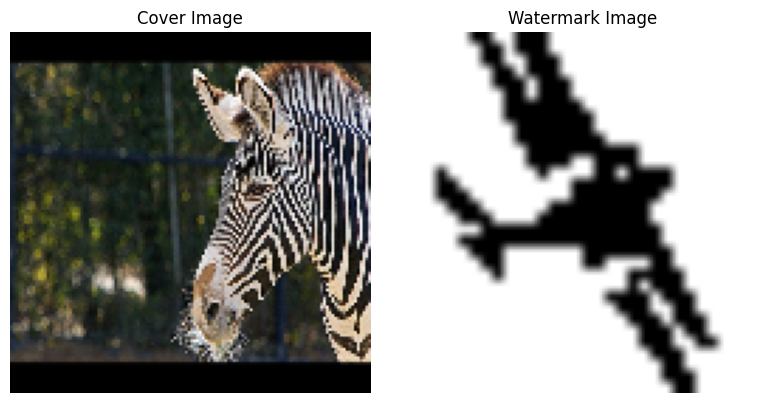

In [8]:
%matplotlib inline

# Take one batch from dataset
for input_tensor, label_tensor in train_ds.take(1):
    input_image = input_tensor[0].numpy()
    label_image = label_tensor[0].numpy()

    print("Input image shape:", input_image.shape)
    print("Watermark image shape:", label_image.shape)

    # Show images
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title("Cover Image")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Watermark Image")
    plt.imshow(label_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


In [9]:
# Check image mode before converting
for path in train_cover_paths[:5]:
    img = Image.open(path)
    print(f"{path} — Mode: {img.mode}")

for path in train_mark_paths[:5]:
    img = Image.open(path)
    print(f"{path} — Mode: {img.mode}")


/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/cover/ILSVRC2012_val_00005002.JPEG — Mode: RGB
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/cover/ILSVRC2012_val_00005003.JPEG — Mode: RGB
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/cover/ILSVRC2012_val_00005004.JPEG — Mode: RGB
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/cover/ILSVRC2012_val_00005010.JPEG — Mode: RGB
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/cover/ILSVRC2012_val_00005014.JPEG — Mode: RGB
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/mark/airplane0003.png — Mode: L
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/mark/airplane0004.png — Mode: L
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/mark/airplane0006.png — Mode: L
/kaggle/input/image-watermarking-datasetcover-mark/dataset/train/mark/airplane0007.png — Mode: L
/kaggle/input/image-watermarking-datasetcover-mark/d

Input (Cover) image shape: (128, 128, 3)
Label (Watermark) image shape: (128, 128, 3)


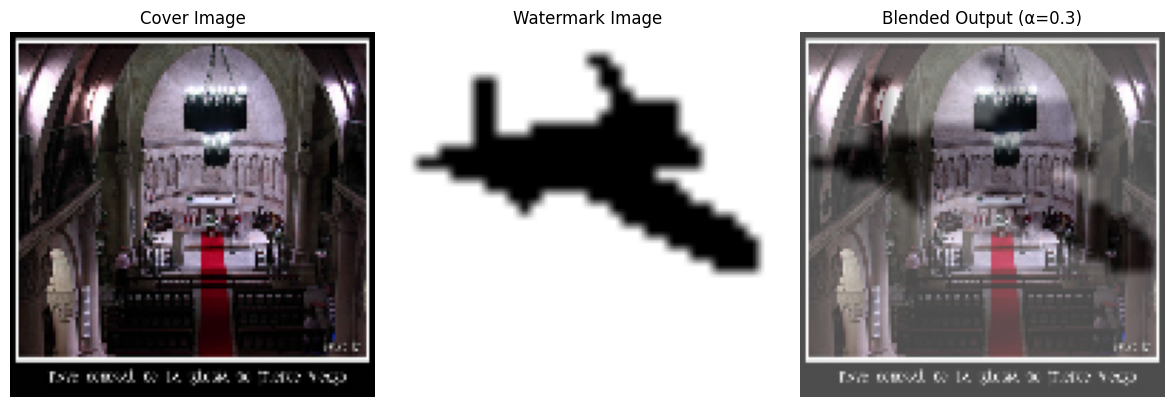

In [13]:
%matplotlib inline

alpha = 0.3  # Blending weight

# Take one batch from dataset
for input_tensor, label_tensor in train_ds.take(1):
    # Take the first image in the batch
    input_image = input_tensor[0].numpy()
    label_image = label_tensor[0].numpy()

    print("Input (Cover) image shape:", input_image.shape)
    print("Label (Watermark) image shape:", label_image.shape)

    # Normalize to [0, 1] if needed
    if input_image.max() > 1.0:
        input_image = input_image / 255.0
    if label_image.max() > 1.0:
        label_image = label_image / 255.0

    # Apply alpha blending
    blended_image = (1 - alpha) * input_image + alpha * label_image
    blended_image = np.clip(blended_image, 0, 1)

    # Show all three images
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Cover Image")
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Watermark Image")
    plt.imshow(label_image)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title(f"Blended Output (α={alpha})")
    plt.imshow(blended_image)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
    break  # Only process one batch


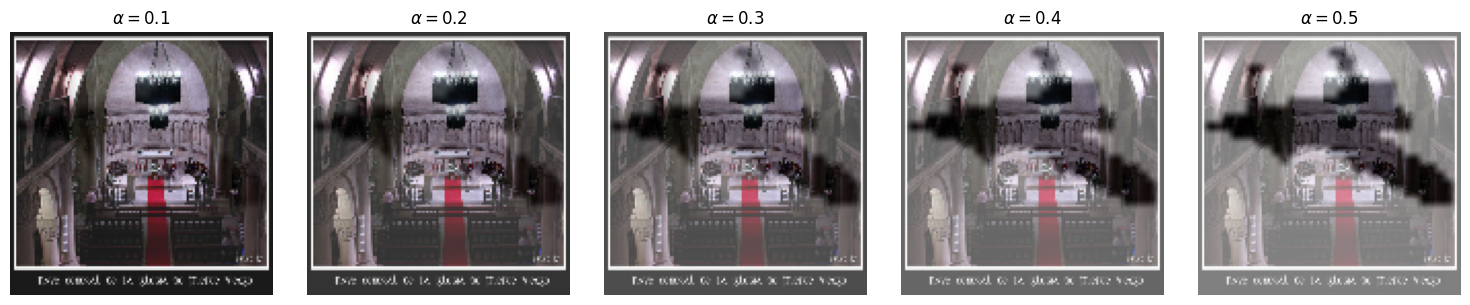

In [14]:
#Test alpha-blending values before training models
import numpy as np
import matplotlib.pyplot as plt

# input_image, label_image: shape (H, W, 3), values in [0,1]
alphas = [0.1, 0.2, 0.3, 0.4, 0.5]

fig, axes = plt.subplots(1, len(alphas), figsize=(3*len(alphas), 3))
for ax, alpha in zip(axes, alphas):
    blended = (1 - alpha) * input_image + alpha * label_image
    blended = np.clip(blended, 0, 1)
    ax.imshow(blended)
    ax.set_title(rf"$\alpha = {alpha}$")
    ax.axis("off")

plt.tight_layout()
plt.savefig("alpha_gallery_row.png", dpi=300, bbox_inches="tight")
plt.show()


In [8]:
#Test  and compare the PSNR, MSE, SSIM for different alpha-blending values.
import numpy as np
from io import BytesIO
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# Helpers (images in [0,1], HxWx3)
def clip01(x): return np.clip(x, 0.0, 1.0)
def to_uint8(x01): return (clip01(x01)*255.0 + 0.5).astype(np.uint8)
def _jpeg(img01, quality=50):
    buf = BytesIO(); Image.fromarray(to_uint8(img01)).save(buf, "JPEG", quality=int(quality))
    buf.seek(0); return np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32)/255.0
def psnr(a,b,eps=1e-12): 
    mse = np.mean((a-b)**2); return 10.0*np.log10(1.0/(mse+eps))
def ssim3(a,b): return ssim(a,b,channel_axis=-1, data_range=1.0)
def to_gray01(img01): 
    r,g,b = img01[...,0], img01[...,1], img01[...,2]; return clip01(0.299*r+0.587*g+0.114*b)
def bin01(x,thr=0.5): return (x>=thr).astype(np.uint8)
def ber_bits(a,b): a=a.ravel().astype(np.uint8); b=b.ravel().astype(np.uint8); return float(np.mean(a^b))*100.0
def nc_bits(a,b):
    a=(a*2-1).astype(np.int32).ravel(); b=(b*2-1).astype(np.int32).ravel()
    denom = (np.linalg.norm(a)*np.linalg.norm(b) + 1e-12); return float(np.dot(a,b)/denom)

def embed(C,W,alpha): return clip01((1-alpha)*C + alpha*W)
def extract(Yatt,C,alpha): return clip01((Yatt - C)/max(alpha,1e-8))

# α-sweep over a few batches (imperceptibility + recovery under JPEG QF50)
alphas = [0.1,0.2,0.3,0.4,0.5]
attack_quality = 50
max_batches = 5   # increase if you want more coverage

stats = []  # list of dicts per alpha

for a in alphas:
    psnrs, ssims, bers, ncs = [], [], [], []
    batch_count = 0
    for input_tensor, label_tensor in train_ds:
        # stop after some batches to keep it fast
        batch_count += 1
        if batch_count > max_batches: break

        X = input_tensor.numpy()    # (B,H,W,3)
        Y = label_tensor.numpy()    # (B,H,W,3)
        if X.max() > 1.0: X = X/255.0
        if Y.max() > 1.0: Y = Y/255.0

        for i in range(X.shape[0]):
            C = X[i]; W = Y[i]
            Yblend = embed(C,W,a)

            # imperceptibility vs cover
            psnrs.append(psnr(Yblend, C))
            ssims.append(ssim3(Yblend, C))

            # fixed attack (JPEG)
            Yatt = _jpeg(Yblend, quality=attack_quality)

            # analytic extraction and bit metrics
            What = extract(Yatt, C, a)
            Wb   = bin01(to_gray01(W))
            What_b = bin01(to_gray01(What))
            bers.append(ber_bits(Wb, What_b))
            ncs.append(nc_bits(Wb, What_b))

    stats.append({
        "alpha": a,
        "PSNR_med": float(np.median(psnrs)) if psnrs else float("nan"),
        "SSIM_med": float(np.median(ssims)) if ssims else float("nan"),
        "BER_med_%": float(np.median(bers)) if bers else float("nan"),
        "NC_med": float(np.median(ncs)) if ncs else float("nan"),
        "N_samples": len(psnrs)
    })

# Results
for r in stats:
    print(f"α={r['alpha']:.1f} | PSNR_med={r['PSNR_med']:.2f} dB | SSIM_med={r['SSIM_med']:.3f} | "
          f"BER_med={r['BER_med_%']:.2f}% | NC_med={r['NC_med']:.3f} | N={r['N_samples']}")


α=0.1 | PSNR_med=25.17 dB | SSIM_med=0.943 | BER_med=28.30% | NC_med=0.763 | N=160
α=0.2 | PSNR_med=19.41 dB | SSIM_med=0.869 | BER_med=31.04% | NC_med=0.755 | N=160
α=0.3 | PSNR_med=15.63 dB | SSIM_med=0.778 | BER_med=26.07% | NC_med=0.763 | N=160
α=0.4 | PSNR_med=13.34 dB | SSIM_med=0.676 | BER_med=25.63% | NC_med=0.781 | N=160
α=0.5 | PSNR_med=11.27 dB | SSIM_med=0.570 | BER_med=26.75% | NC_med=0.761 | N=160


### Pre-processing for LinearSVR and GBM

In [5]:
#Preparing dataset for embedding (Training and Testing)

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
def prepare_data_for_embedding(cover_paths, mark_paths, size=(128, 128), alpha=0.3):
    input_list, output_list = [], []
    for c_path, m_path in zip(cover_paths, mark_paths):
        cover = Image.open(c_path).convert("RGB").resize(size)
        mark = Image.open(m_path).convert("RGB").resize(size)

        cover_arr = np.array(cover, dtype=np.float32).flatten() / 255.0
        mark_arr = np.array(mark, dtype=np.float32).flatten() / 255.0

        input_vector = np.hstack([cover_arr, mark_arr]) 
        blended = (1 - alpha) * cover_arr + alpha * mark_arr 

        input_list.append(input_vector)
        output_list.append(blended)

    return np.array(input_list), np.array(output_list)

# Used 5000 images for training and 1000 images for testing
X_train_raw, y_train_raw = prepare_data_for_embedding(train_cover_paths[:5000], train_mark_paths[:5000])
X_test_raw, y_test_raw = prepare_data_for_embedding(test_cover_paths[:1000], test_mark_paths[:1000])


# Step 1: Scale input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Step 2: Reduce dimensions using PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

#Step 3: Scale output features
output_scaler = MinMaxScaler()
y_train_scaled = output_scaler.fit_transform(y_train_raw)
y_test_scaled = output_scaler.transform(y_test_raw)

#Step 4: Reduce dimenions uing PCA
output_pca = PCA(n_components=50)
y_train_pca = output_pca.fit_transform(y_train_scaled)
y_test_pca = output_pca.transform(y_test_scaled)

### LinearSVR Pipeline

In [7]:
import numpy as np
from time import perf_counter
from contextlib import suppress
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from codecarbon import EmissionsTracker
import joblib

# helpers
def start_tracker(name, output_dir="."):
    try:
        tr = EmissionsTracker(project_name=name, output_dir=output_dir, measure_power_secs=1)
        tr.start()
        return tr
    except Exception as e:
        print(f"[WARN] CodeCarbon disabled for '{name}': {e}", flush=True)
        return None

def stop_tracker(tr):
    if tr is None:
        return None
    with suppress(Exception):
        return tr.stop()
    return None

def psnr_from_mse(mse, max_i=1.0, eps=1e-12):
    return 10.0 * np.log10((max_i**2) / (mse + eps))

def dataset_ssim_one_number(y_true_vec, y_pred_vec, H=None, W=None, C=3):
    n, d = y_true_vec.shape
    if H is None or W is None:
        HW = d // C
        side = int(round(HW ** 0.5))
        if side * side * C == d:
            H = W = side
        else:
            # fallback to 128 if not square; set to your true size if different
            H = W = 128
    y_true_imgs = y_true_vec.reshape(n, H, W, C)
    y_pred_imgs = y_pred_vec.reshape(n, H, W, C)
    y_true_big = np.concatenate([y_true_imgs[i] for i in range(n)], axis=0)  # (n*H, W, C)
    y_pred_big = np.concatenate([y_pred_imgs[i] for i in range(n)], axis=0)

    try:
        return ssim(y_true_big, y_pred_big, data_range=1.0, channel_axis=2)
    except TypeError:
        return ssim(y_true_big, y_pred_big, data_range=1.0, multichannel=True)

# TRAIN (timing + CO2)
train_tracker = start_tracker("LinearSVR_Watermarking_Train", output_dir=".")
t0 = perf_counter()

svm_model = LinearSVR(C=0.3, epsilon=0.1, max_iter=30000, tol=1e-2)
svm_ml = MultiOutputRegressor(svm_model)  # or MultiOutputRegressor(svm_model, n_jobs=-1)
svm_ml.fit(X_train_pca, y_train_pca)

train_time_s = perf_counter() - t0
train_emissions_kg = stop_tracker(train_tracker)
N_train = X_train_pca.shape[0]
train_ms_per_img = (train_time_s / N_train) * 1000.0

print(
    f"[TRAIN] LinearSVR total: {train_time_s:.2f}s for {N_train} imgs "
    f"({train_ms_per_img:.2f} ms/img) | CO2: {train_emissions_kg if train_emissions_kg is not None else 'n/a'}",
    flush=True,
)

# INFERENCE (timing + CO2)
infer_tracker = start_tracker("LinearSVR_Watermarking_Inference", output_dir=".")
t1 = perf_counter()

y_pred_pca = svm_ml.predict(X_test_pca)  # (N_test, d_y_pca)

infer_time_s = perf_counter() - t1
infer_emissions_kg = stop_tracker(infer_tracker)
N_test = X_test_pca.shape[0]
infer_ms_per_img = (infer_time_s / N_test) * 1000.0

print(
    f"[INFER] LinearSVR total: {infer_time_s:.4f}s for {N_test} imgs "
    f"({infer_ms_per_img:.2f} ms/img) | CO2: {infer_emissions_kg if infer_emissions_kg is not None else 'n/a'}",
    flush=True,
)

# EVALUATION (single dataset-wide MSE/PSNR/SSIM)
# Assumes: output_pca, output_scaler, y_test_pca exist
# Inverse-transform predictions and ground truth back to image vector space
y_pred_scaled = output_pca.inverse_transform(y_pred_pca)
y_pred = output_scaler.inverse_transform(y_pred_scaled)                # (N_test, H*W*3)

y_test_true = output_scaler.inverse_transform(
    output_pca.inverse_transform(y_test_pca)
)                                                                      # (N_test, H*W*3)

# Clip to [0,1] if that's your convention
y_pred = np.clip(y_pred, 0.0, 1.0)
y_test_true = np.clip(y_test_true, 0.0, 1.0)

# Global MSE/PSNR across all pixels
eps = 1e-12
MAX_I = 1.0  # use 255.0 if your vectors are in [0,255]
svm_mse = mean_squared_error(y_test_true.ravel(), y_pred.ravel())
svm_psnr = psnr_from_mse(svm_mse, max_i=MAX_I, eps=eps)

# Single SSIM (treat all test images as one tall image)
svm_ssim = dataset_ssim_one_number(y_test_true, y_pred)

print(f"[EVAL] LinearSVR MSE: {svm_mse:.6f} | PSNR: {svm_psnr:.2f} dB | SSIM: {svm_ssim:.4f}", flush=True)

# SAVE ARTIFACTS
joblib.dump(svm_ml, "svm_model.pkl", compress=3)
joblib.dump(pca, "pca_x.pkl", compress=3)
joblib.dump(output_pca, "pca_y.pkl", compress=3)
joblib.dump(scaler, "scaler_x.pkl", compress=3)
joblib.dump(output_scaler, "scaler_y.pkl", compress=3)
print("[SAVE] Artifacts written: svm_model.pkl, pca_x.pkl, pca_y.pkl, scaler_x.pkl, scaler_y.pkl", flush=True)

#MODEL SIZE (MB)
import os

def _bytes_to_mb(n): 
    return n / (1024 ** 2)

def artifact_size_mb(paths):
    total = 0
    for p in paths:
        if os.path.exists(p):
            total += os.path.getsize(p)
    return _bytes_to_mb(total)

linear_artifacts = [
    "svm_model.pkl",     # the wrapped MultiOutputRegressor(LinearSVR)
    "pca_x.pkl",         # input PCA
    "pca_y.pkl",         # output PCA
    "scaler_x.pkl",      # StandardScaler
    "scaler_y.pkl"       # MinMaxScaler (or whatever you used for y)
]

linear_total_mb = artifact_size_mb(linear_artifacts)
print(f"[SIZE] LinearSVR (artifacts on disk): {linear_total_mb:.2f} MB "
      f"(joblib compress=3)")



[codecarbon WARNING @ 09:12:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:12:55] [setup] RAM Tracking...
[codecarbon INFO @ 09:12:55] [setup] CPU Tracking...
[codecarbon WARNING @ 09:12:56] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 09:12:56] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 09:12:56] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 09:12:56] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:12:56] [setup] GPU Tracking...
[codecarbon INFO @ 09:12:56] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:12:56] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

[TRAIN] LinearSVR total: 1044.28s for 5000 imgs (208.86 ms/img) | CO2: 0.015642495345581663


[codecarbon WARNING @ 09:30:23] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 09:30:23] [setup] RAM Tracking...
[codecarbon INFO @ 09:30:23] [setup] CPU Tracking...
[codecarbon WARNING @ 09:30:24] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 09:30:24] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 09:30:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 09:30:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 09:30:24] [setup] GPU Tracking...
[codecarbon INFO @ 09:30:24] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 09:30:24] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

[INFER] LinearSVR total: 0.0241s for 1000 imgs (0.02 ms/img) | CO2: 2.3342299364570927e-07
[EVAL] LinearSVR MSE: 0.003679 | PSNR: 24.34 dB | SSIM: 0.8057
[SAVE] Artifacts written: svm_model.pkl, pca_x.pkl, pca_y.pkl, scaler_x.pkl, scaler_y.pkl
[SIZE] LinearSVR (artifacts on disk): 22.37 MB (joblib compress=3)


### LinearSVR (Noise attack and Extraction)


[ROBUSTNESS — dataset mean metrics]
Clean        -> MSE: 0.003679 | PSNR: 24.87 dB | SSIM: 0.8037 | BER: 0.3289 (n=1000) | NC(±1): 0.3422
JPEG(q=50)   -> MSE: 0.003740 | PSNR: 24.78 dB | SSIM: 0.7844 | BER: 0.3302 (n=1000) | NC(±1): 0.3396
Gaussian(0.01) -> MSE: 0.003777 | PSNR: 24.73 dB | SSIM: 0.7615 | BER: 0.3289 (n=1000) | NC(±1): 0.3421
Crop(10%)    -> MSE: 0.010582 | PSNR: 20.39 dB | SSIM: 0.6795 | BER: 0.3552 (n=1000) | NC(±1): 0.2896


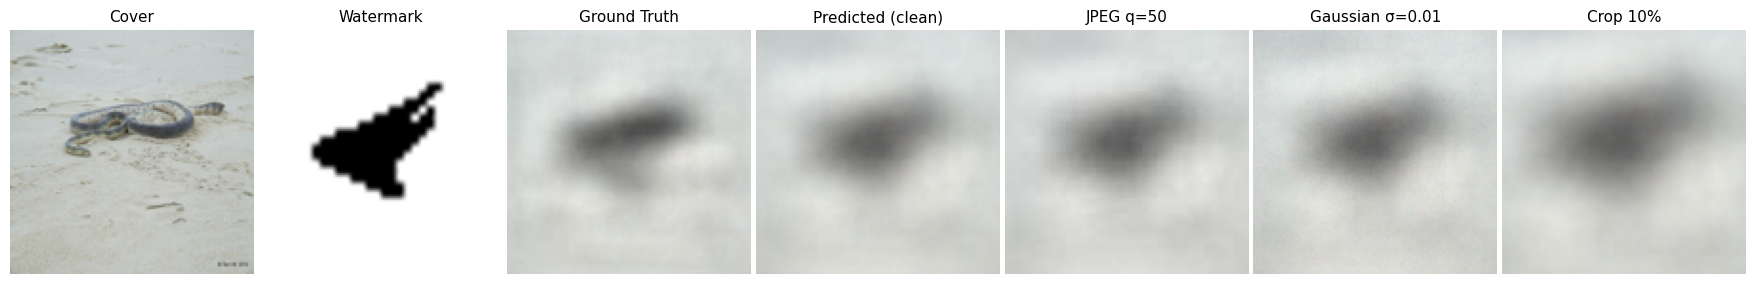

[SAVED] linearSVR_robustness_row.png


In [11]:
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# config for extraction
ALPHA  = 0.3     # must match training blend alpha
THRESH = 0.5     # binarization threshold for watermark bits

# helpers (expects float images in [0,1], HxWxC)
def _jpeg(img01, quality=50):
    buf = BytesIO()
    Image.fromarray((img01 * 255.0).astype(np.uint8)).save(buf, format="JPEG", quality=int(quality))
    buf.seek(0)
    out = np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32) / 255.0
    return out

def _gaussian(img01, sigma=0.01):
    n = np.random.normal(0.0, float(sigma), img01.shape).astype(np.float32)
    return np.clip(img01 + n, 0.0, 1.0)

def _crop_and_resize(img01, crop_ratio=0.10):
    h, w = img01.shape[:2]
    dy = int(round(h * crop_ratio)); dx = int(round(w * crop_ratio))
    if dy == 0 and dx == 0 or (h - 2*dy) <= 0 or (w - 2*dx) <= 0:
        return img01.copy()
    crop = img01[dy:h-dy, dx:w-dx, :]
    out = np.asarray(
        Image.fromarray((crop * 255).astype(np.uint8)).resize((w, h), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0
    return out

def _psnr_from_images(a, b, eps=1e-12):
    mse = float(np.mean((a - b) ** 2))
    psnr = 10.0 * np.log10((1.0**2) / (mse + eps))
    return mse, psnr

def _ssim_img(a, b):
    try:    return ssim(a, b, data_range=1.0, channel_axis=2)
    except TypeError: return ssim(a, b, data_range=1.0, multichannel=True)

# ---- extraction helpers ----
def _to_gray01(img):
    if img.ndim == 3 and img.shape[2] == 3:
        return (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.float32)
    return img.astype(np.float32)

def _binarize01(gray, thr=0.5):
    return (gray >= float(thr)).astype(np.uint8)

def _ber(a_bin, b_bin):
    return float(np.mean(a_bin != b_bin))

def _nc_classic(a_bin, b_bin, eps=1e-12):
    # Convert {0,1} -> {-1,+1}, then cosine similarity
    a = (a_bin.astype(np.float32) * 2.0) - 1.0
    b = (b_bin.astype(np.float32) * 2.0) - 1.0
    return float((a*b).sum() / (np.sqrt((a*a).sum())*np.sqrt((b*b).sum()) + eps))

def _extract_watermark(Y_obs, C_cover, alpha=ALPHA):
    if alpha <= 0:
        raise ValueError("ALPHA must be > 0 for extraction.")
    W_hat = (Y_obs - C_cover) / float(alpha)
    return np.clip(W_hat, 0.0, 1.0)

def _get_cover_mark(i):
    """Return (cover_img01, mark_img01) in [0,1], or (None,None) if unavailable."""
    # from raw concatenation if present
    if 'X_test_raw' in globals():
        try:
            d2 = X_test_raw.shape[1] // 2
            cover_img = X_test_raw[i, :d2].reshape(H, W, C).astype(np.float32)
            mark_img  = X_test_raw[i, d2:].reshape(H, W, C).astype(np.float32)
            return np.clip(cover_img, 0.0, 1.0), np.clip(mark_img, 0.0, 1.0)
        except Exception:
            pass
    # from file paths if present
    if 'test_cover_paths' in globals() and 'test_mark_paths' in globals():
        try:
            cov = Image.open(test_cover_paths[i]).convert("RGB").resize((W, H))
            mrk = Image.open(test_mark_paths[i]).convert("RGB").resize((W, H))
            return (np.asarray(cov, dtype=np.float32)/255.0,
                    np.asarray(mrk, dtype=np.float32)/255.0)
        except Exception:
            pass
    return None, None

# vector -> image tensors for robustness
# takes y_pred and y_test_true from your eval block
C = 3
n, d = y_pred.shape
HW = d // C
side = int(round(HW ** 0.5))
if side * side * C == d:
    H = W = side
else:
    # TODO: set to your actual size if not square-inferred
    H = W = 128

y_true_imgs = y_test_true.reshape(n, H, W, C)
y_pred_imgs = y_pred.reshape(n, H, W, C)

# evaluate a transform over the whole test set:
# mean per-image MSE/PSNR/SSIM and (if cover/mark available) BER/NC from extraction
def _eval_attack(transform):
    mses, psnrs, ssims = [], [], []
    bers, ncs = [], []
    have_pairs = True
    for i in range(n):
        Yt = y_true_imgs[i]          # blended ground truth
        Yp = y_pred_imgs[i]          # clean predicted
        Ya = transform(Yp)           # attacked predicted

        # image-level metrics vs ground truth blended
        mse_i, psnr_i = _psnr_from_images(Yt, Ya)
        mses.append(mse_i); psnrs.append(psnr_i); ssims.append(_ssim_img(Yt, Ya))

        # extraction metrics (require cover & true watermark)
        C_img, W_true = _get_cover_mark(i)
        if C_img is None or W_true is None:
            have_pairs = False
            continue
        W_hat  = _extract_watermark(Ya, C_img, alpha=ALPHA)
        Wt_bin = _binarize01(_to_gray01(W_true), thr=THRESH)
        Wh_bin = _binarize01(_to_gray01(W_hat),  thr=THRESH)
        bers.append(_ber(Wt_bin, Wh_bin))
        ncs.append(_nc_classic(Wt_bin, Wh_bin))   # classic ±1 NC

    out = {
        "mse": float(np.mean(mses)),
        "psnr": float(np.mean(psnrs)),
        "ssim": float(np.mean(ssims)),
        "have_pairs": have_pairs and len(bers) == n,   # True if we had pairs for all i
        "ber": float(np.mean(bers)) if len(bers) else None,
        "nc":  float(np.mean(ncs))  if len(ncs)  else None,
        "ber_n": len(bers)
    }
    return out

# Run clean + three attacks
res_clean = _eval_attack(lambda img: img)                # identity (no attack)
res_jpeg  = _eval_attack(lambda img: _jpeg(img, quality=50))
res_gaus  = _eval_attack(lambda img: _gaussian(img, sigma=0.01))
res_crop  = _eval_attack(lambda img: _crop_and_resize(img, crop_ratio=0.10))

print("\n[ROBUSTNESS — dataset mean metrics]")
def _line(name, r):
    base = f"{name:<12} -> MSE: {r['mse']:.6f} | PSNR: {r['psnr']:.2f} dB | SSIM: {r['ssim']:.4f}"
    if r['ber'] is not None and r['nc'] is not None:
        base += f" | BER: {r['ber']:.4f} (n={r['ber_n']}) | NC(±1): {r['nc']:.4f}"
    else:
        base += " | BER/NC: n/a (need cover+watermark)"
    print(base)

_line("Clean",          res_clean)
_line("JPEG(q=50)",     res_jpeg)
_line("Gaussian(0.01)", res_gaus)
_line("Crop(10%)",      res_crop)

# Vizualisation
viz_idx = 0  # change if you want another sample

Yt = y_true_imgs[viz_idx]      # ground truth blended
Yp = y_pred_imgs[viz_idx]      # clean prediction
Yp_jpeg = _jpeg(Yp, quality=50)
Yp_gaus = _gaussian(Yp, sigma=0.01)
Yp_crop = _crop_and_resize(Yp, crop_ratio=0.10)

# try to get cover & watermark for display (best-effort)
cover_img, mark_img = _get_cover_mark(viz_idx)

# Single-row figure
panels = [
    (cover_img if cover_img is not None else np.zeros_like(Yt), "Cover"),
    (mark_img  if mark_img  is not None else np.zeros_like(Yt), "Watermark"),
    (Yt,       "Ground Truth"),
    (Yp,       "Predicted (clean)"),
    (Yp_jpeg,  "JPEG q=50"),
    (Yp_gaus,  "Gaussian σ=0.01"),
    (Yp_crop,  "Crop 10%"),
]

w_per_img, h_in = 3.2, 3.2
fig, axes = plt.subplots(1, len(panels), figsize=(w_per_img*len(panels), h_in))
for ax, (img, title) in zip(axes, panels):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title, fontsize=11)
    ax.axis("off")
plt.subplots_adjust(wspace=0.02, hspace=0)

out_path = "linearSVR_robustness_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()
print(f"[SAVED] {out_path}")

### GBM PIPELINE

In [ ]:
import numpy as np
from time import perf_counter
from contextlib import suppress
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from skimage.metrics import structural_similarity as ssim
from codecarbon import EmissionsTracker
import joblib, os

# helpers
def start_tracker(name, output_dir="."):
    try:
        tr = EmissionsTracker(project_name=name, output_dir=output_dir, measure_power_secs=1)
        tr.start()
        return tr
    except Exception as e:
        print(f"[WARN] CodeCarbon disabled for '{name}': {e}", flush=True)
        return None

def stop_tracker(tr):
    if tr is None:
        return None
    with suppress(Exception):
        return tr.stop()
    return None

def psnr_from_mse(mse, max_i=1.0, eps=1e-12):
    return 10.0 * np.log10((max_i**2) / (mse + eps))

def dataset_ssim_one_number(y_true_vec, y_pred_vec, H=None, W=None, C=3):
    n, d = y_true_vec.shape
    if H is None or W is None:
        HW = d // C
        side = int(round(HW ** 0.5))
        if side * side * C == d:
            H = W = side
        else:
            H = W = 128  # fallback if not square; set to your true size if different
    y_true_imgs = y_true_vec.reshape(n, H, W, C)
    y_pred_imgs = y_pred_vec.reshape(n, H, W, C)
    y_true_big = np.concatenate([y_true_imgs[i] for i in range(n)], axis=0)  # (n*H, W, C)
    y_pred_big = np.concatenate([y_pred_imgs[i] for i in range(n)], axis=0)
    try:
        return ssim(y_true_big, y_pred_big, data_range=1.0, channel_axis=2)
    except TypeError:
        return ssim(y_true_big, y_pred_big, data_range=1.0, multichannel=True)

# PSNR scorer used in GridSearchCV
def _psnr_score(y_true, y_pred):
    mse = float(np.mean((y_true - y_pred) ** 2))
    if mse <= 0:  # numerical guard
        return 100.0
    return 20.0 * np.log10(1.0 / np.sqrt(mse))
psnr_scorer = make_scorer(_psnr_score, greater_is_better=True)

# Hyperparameter grid
param_grid = {
    "estimator__learning_rate": [0.05, 0.1],
    "estimator__n_estimators":  [100, 300],
    "estimator__max_depth":     [3, 5],
}

# TRAIN (timing + CO2)
#  Assumes: X_train_pca, y_train_pca exist
train_tracker = start_tracker("GBM_Watermarking_Train", output_dir=".")
t0 = perf_counter()

gbm = GradientBoostingRegressor(random_state=42)
gbm_multi = MultiOutputRegressor(gbm)  # wrapper for multi-d output

grid = GridSearchCV(
    estimator=gbm_multi,
    param_grid=param_grid,
    scoring=psnr_scorer,   # custom PSNR metric
    cv=3,
    n_jobs=-1,
    refit=True,
    verbose=0
)
grid.fit(X_train_pca, y_train_pca)

train_time_s = perf_counter() - t0
train_emissions_kg = stop_tracker(train_tracker)
N_train = X_train_pca.shape[0]
train_ms_per_img = (train_time_s / N_train) * 1000.0

print(
    f"[TRAIN] GBM total: {train_time_s:.2f}s for {N_train} imgs "
    f"({train_ms_per_img:.2f} ms/img) | CO2: {train_emissions_kg if train_emissions_kg is not None else 'n/a'}",
    flush=True,
)
print(f"[TRAIN][CV] best_params={grid.best_params_} | best_PSNR={grid.best_score_:.2f} dB", flush=True)

best_gbm = grid.best_estimator_

# INFERENCE (timing + CO2)
infer_tracker = start_tracker("GBM_Watermarking_Inference", output_dir=".")
t1 = perf_counter()

y_pred_pca = best_gbm.predict(X_test_pca)  # (N_test, d_y_pca)

infer_time_s = perf_counter() - t1
infer_emissions_kg = stop_tracker(infer_tracker)
N_test = X_test_pca.shape[0]
infer_ms_per_img = (infer_time_s / N_test) * 1000.0

print(
    f"[INFER] GBM total: {infer_time_s:.4f}s for {N_test} imgs "
    f"({infer_ms_per_img:.2f} ms/img) | CO2: {infer_emissions_kg if infer_emissions_kg is not None else 'n/a'}",
    flush=True,
)

# EVALUATION (single dataset-wide MSE/PSNR/SSIM)
# Inverse-transform predictions and ground truth back to image vector space
y_pred_scaled = output_pca.inverse_transform(y_pred_pca)
y_pred = output_scaler.inverse_transform(y_pred_scaled)                # (N_test, H*W*3)

y_test_true = output_scaler.inverse_transform(
    output_pca.inverse_transform(y_test_pca)
)                                                                      # (N_test, H*W*3)

# Clip to [0,1] if that's your convention
y_pred = np.clip(y_pred, 0.0, 1.0)
y_test_true = np.clip(y_test_true, 0.0, 1.0)

# Global MSE/PSNR across all pixels
eps = 1e-12
MAX_I = 1.0
gbm_mse  = mean_squared_error(y_test_true.ravel(), y_pred.ravel())
gbm_psnr = psnr_from_mse(gbm_mse, max_i=MAX_I, eps=eps)

# Single SSIM (treat all test images as one tall image)
gbm_ssim = dataset_ssim_one_number(y_test_true, y_pred)

print(f"[EVAL] GBM MSE: {gbm_mse:.6f} | PSNR: {gbm_psnr:.2f} dB | SSIM: {gbm_ssim:.4f}", flush=True)

# SAVE ARTIFACTS (model only; PCA/scalers already exist)
joblib.dump(best_gbm, "gbm_model.pkl", compress=3)
print("[SAVE] Artifacts written: gbm_model.pkl", flush=True)

# MODEL SIZE (MB)
def _bytes_to_mb(n): 
    return n / (1024 ** 2)

def artifact_size_mb(paths):
    total = 0
    for p in paths:
        if os.path.exists(p):
            total += os.path.getsize(p)
    return _bytes_to_mb(total)

gbm_artifacts = [
    "gbm_model.pkl",   # this run's model
    "pca_x.pkl",       # reuse existing pre/post files to be comparable with LinearSVR
    "pca_y.pkl",
    "scaler_x.pkl",
    "scaler_y.pkl",
]
gbm_total_mb = artifact_size_mb(gbm_artifacts)
print(f"[SIZE] GBM (artifacts on disk): {gbm_total_mb:.2f} MB (joblib compress=3)")

[codecarbon WARNING @ 10:58:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 10:58:37] [setup] RAM Tracking...
[codecarbon INFO @ 10:58:37] [setup] CPU Tracking...
[codecarbon WARNING @ 10:58:38] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 10:58:38] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 10:58:38] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 10:58:38] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 10:58:38] [setup] GPU Tracking...
[codecarbon INFO @ 10:58:38] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 10:58:38] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

In [8]:
print(
    f"[TRAIN] GBM total: {train_time_s:.2f}s for {N_train} imgs "
    f"({train_ms_per_img:.2f} ms/img) | CO2: {train_emissions_kg if train_emissions_kg is not None else 'n/a'}",
    flush=True,
)
print(f"[TRAIN][CV] best_params={grid.best_params_} | best_PSNR={grid.best_score_:.2f} dB", flush=True)

print(
    f"[INFER] GBM total: {infer_time_s:.4f}s for {N_test} imgs "
    f"({infer_ms_per_img:.2f} ms/img) | CO2: {infer_emissions_kg if infer_emissions_kg is not None else 'n/a'}",
    flush=True,
)

print(f"[EVAL] GBM MSE: {gbm_mse:.6f} | PSNR: {gbm_psnr:.2f} dB | SSIM: {gbm_ssim:.4f}", flush=True)

# 4) SAVE ARTIFACTS
joblib.dump(best_gbm, "gbm_model.pkl", compress=3)
print("[SAVE] Artifacts written: gbm_model.pkl", flush=True)
print(f"[SIZE] GBM (artifacts on disk): {gbm_total_mb:.2f} MB (joblib compress=3)")


[TRAIN] GBM total: 7212.22s for 5000 imgs (1442.44 ms/img) | CO2: 0.11380933425806301
[TRAIN][CV] best_params={'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 300} | best_PSNR=-6.58 dB
[INFER] GBM total: 0.2021s for 1000 imgs (0.20 ms/img) | CO2: 3.264156681320482e-06
[EVAL] GBM MSE: 0.004228 | PSNR: 23.74 dB | SSIM: 0.7931
[SAVE] Artifacts written: gbm_model.pkl
[SIZE] GBM (artifacts on disk): 5.46 MB (joblib compress=3)


### GBM (Noise Attack and Extraction)


[ROBUSTNESS — dataset mean metrics]
Clean        -> MSE: 0.004228 | PSNR: 24.25 dB | SSIM: 0.7912 | BER: 0.3358 (n=1000) | NC(±1): 0.3284
JPEG(q=50)   -> MSE: 0.004288 | PSNR: 24.17 dB | SSIM: 0.7723 | BER: 0.3370 (n=1000) | NC(±1): 0.3260
Gaussian(0.01) -> MSE: 0.004327 | PSNR: 24.12 dB | SSIM: 0.7485 | BER: 0.3359 (n=1000) | NC(±1): 0.3282
Crop(10%)    -> MSE: 0.010726 | PSNR: 20.32 dB | SSIM: 0.6751 | BER: 0.3614 (n=1000) | NC(±1): 0.2772


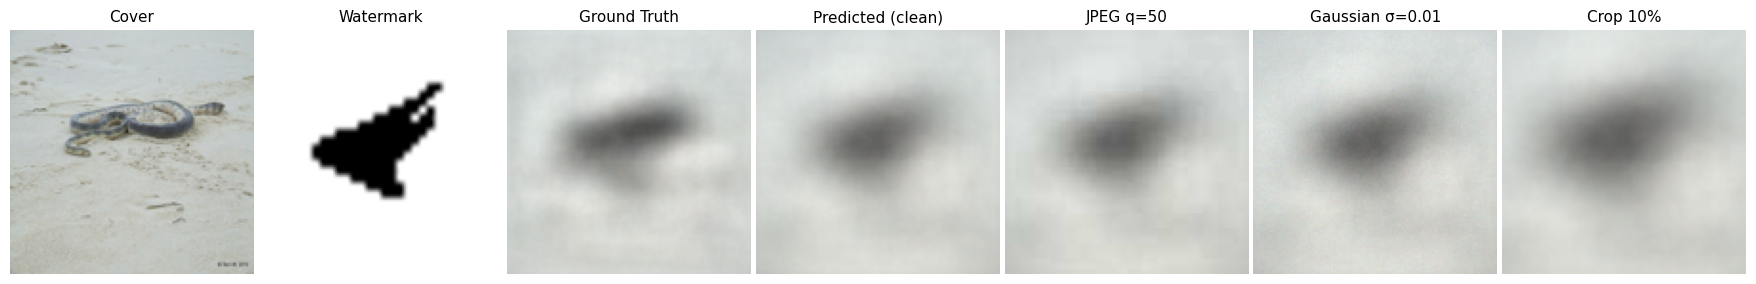

[SAVED] gbm_robustness_row.png


In [9]:
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

# config for extraction
ALPHA  = 0.3     # blend alpha used to create blended target
THRESH = 0.5     # binarization threshold for watermark bits

# helpers (expects float images in [0,1], HxWxC)
def _jpeg(img01, quality=50):
    buf = BytesIO()
    Image.fromarray((img01 * 255.0).astype(np.uint8)).save(buf, format="JPEG", quality=int(quality))
    buf.seek(0)
    out = np.asarray(Image.open(buf).convert("RGB"), dtype=np.float32) / 255.0
    return out

def _gaussian(img01, sigma=0.01):
    n = np.random.normal(0.0, float(sigma), img01.shape).astype(np.float32)
    return np.clip(img01 + n, 0.0, 1.0)

def _crop_and_resize(img01, crop_ratio=0.10):
    h, w = img01.shape[:2]
    dy = int(round(h * crop_ratio)); dx = int(round(w * crop_ratio))
    if dy == 0 and dx == 0 or (h - 2*dy) <= 0 or (w - 2*dx) <= 0:
        return img01.copy()
    crop = img01[dy:h-dy, dx:w-dx, :]
    out = np.asarray(
        Image.fromarray((crop * 255).astype(np.uint8)).resize((w, h), Image.BILINEAR),
        dtype=np.float32
    ) / 255.0
    return out

def _psnr_from_images(a, b, eps=1e-12):
    mse = float(np.mean((a - b) ** 2))
    psnr = 10.0 * np.log10((1.0**2) / (mse + eps))
    return mse, psnr

def _ssim_img(a, b):
    try:    return ssim(a, b, data_range=1.0, channel_axis=2)
    except TypeError: return ssim(a, b, data_range=1.0, multichannel=True)

# extraction helpers
def _to_gray01(img):
    if img.ndim == 3 and img.shape[2] == 3:
        return (0.299*img[...,0] + 0.587*img[...,1] + 0.114*img[...,2]).astype(np.float32)
    return img.astype(np.float32)

def _binarize01(gray, thr=0.5):
    return (gray >= float(thr)).astype(np.uint8)

def _ber(a_bin, b_bin):
    return float(np.mean(a_bin != b_bin))

def _nc_classic(a_bin, b_bin, eps=1e-12):
    # Convert {0,1} -> {-1,+1}, then cosine similarity
    a = (a_bin.astype(np.float32) * 2.0) - 1.0
    b = (b_bin.astype(np.float32) * 2.0) - 1.0
    return float((a*b).sum() / (np.sqrt((a*a).sum())*np.sqrt((b*b).sum()) + eps))

def _extract_watermark(Y_obs, C_cover, alpha=ALPHA):
    if alpha <= 0:
        raise ValueError("ALPHA must be > 0 for extraction.")
    W_hat = (Y_obs - C_cover) / float(alpha)
    return np.clip(W_hat, 0.0, 1.0)

def _get_cover_mark(i):
    """Return (cover_img01, mark_img01) in [0,1], or (None,None) if unavailable."""
    # from raw concatenation if present
    if 'X_test_raw' in globals():
        try:
            d2 = X_test_raw.shape[1] // 2
            cover_img = X_test_raw[i, :d2].reshape(H, W, C).astype(np.float32)
            mark_img  = X_test_raw[i, d2:].reshape(H, W, C).astype(np.float32)
            return np.clip(cover_img, 0.0, 1.0), np.clip(mark_img, 0.0, 1.0)
        except Exception:
            pass
    # from file paths if present
    if 'test_cover_paths' in globals() and 'test_mark_paths' in globals():
        try:
            cov = Image.open(test_cover_paths[i]).convert("RGB").resize((W, H))
            mrk = Image.open(test_mark_paths[i]).convert("RGB").resize((W, H))
            return (np.asarray(cov, dtype=np.float32)/255.0,
                    np.asarray(mrk, dtype=np.float32)/255.0)
        except Exception:
            pass
    return None, None

# vector -> image tensors (use GBM's y_pred / y_test_true)
C = 3
n, d = y_pred.shape
HW = d // C
side = int(round(HW ** 0.5))
if side * side * C == d:
    H = W = side
else:
    H = W = 128  # set to your actual size if not square-inferred

y_true_imgs = y_test_true.reshape(n, H, W, C)
y_pred_imgs = y_pred.reshape(n, H, W, C)

# evaluate a transform over the whole test set:
# mean per-image MSE/PSNR/SSIM and (if cover/mark available) BER/NC from extraction
def _eval_attack(transform):
    mses, psnrs, ssims = [], [], []
    bers, ncs = [], []
    have_pairs = True
    for i in range(n):
        Yt = y_true_imgs[i]          # blended ground truth
        Yp = y_pred_imgs[i]          # clean predicted
        Ya = transform(Yp)           # attacked predicted

        # image-level metrics vs ground truth blended
        mse_i, psnr_i = _psnr_from_images(Yt, Ya)
        mses.append(mse_i); psnrs.append(psnr_i); ssims.append(_ssim_img(Yt, Ya))

        # extraction metrics (require cover & true watermark)
        C_img, W_true = _get_cover_mark(i)
        if C_img is None or W_true is None:
            have_pairs = False
            continue
        W_hat  = _extract_watermark(Ya, C_img, alpha=ALPHA)
        Wt_bin = _binarize01(_to_gray01(W_true), thr=THRESH)
        Wh_bin = _binarize01(_to_gray01(W_hat),  thr=THRESH)
        bers.append(_ber(Wt_bin, Wh_bin))
        ncs.append(_nc_classic(Wt_bin, Wh_bin))   # classic ±1 NC

    out = {
        "mse": float(np.mean(mses)),
        "psnr": float(np.mean(psnrs)),
        "ssim": float(np.mean(ssims)),
        "have_pairs": have_pairs and len(bers) == n,   # True if we had pairs for all i
        "ber": float(np.mean(bers)) if len(bers) else None,
        "nc":  float(np.mean(ncs))  if len(ncs)  else None,
        "ber_n": len(bers)
    }
    return out

# Run clean + three attacks
res_clean = _eval_attack(lambda img: img)                # identity (no attack)
res_jpeg  = _eval_attack(lambda img: _jpeg(img, quality=50))
res_gaus  = _eval_attack(lambda img: _gaussian(img, sigma=0.01))
res_crop  = _eval_attack(lambda img: _crop_and_resize(img, crop_ratio=0.10))

print("\n[ROBUSTNESS — dataset mean metrics]")
def _line(name, r):
    base = f"{name:<12} -> MSE: {r['mse']:.6f} | PSNR: {r['psnr']:.2f} dB | SSIM: {r['ssim']:.4f}"
    if r['ber'] is not None and r['nc'] is not None:
        base += f" | BER: {r['ber']:.4f} (n={r['ber_n']}) | NC(±1): {r['nc']:.4f}"
    else:
        base += " | BER/NC: n/a (need cover+watermark)"
    print(base)

_line("Clean",          res_clean)
_line("JPEG(q=50)",     res_jpeg)
_line("Gaussian(0.01)", res_gaus)
_line("Crop(10%)",      res_crop)

# Visualization
viz_idx = 0  # change to view a different test sample

Yt = y_true_imgs[viz_idx]      # ground truth blended
Yp = y_pred_imgs[viz_idx]      # clean prediction
Yp_jpeg = _jpeg(Yp, quality=50)
Yp_gaus = _gaussian(Yp, sigma=0.01)
Yp_crop = _crop_and_resize(Yp, crop_ratio=0.10)

cover_img, mark_img = _get_cover_mark(viz_idx)

panels = [
    (cover_img if cover_img is not None else np.zeros_like(Yt), "Cover"),
    (mark_img  if mark_img  is not None else np.zeros_like(Yt), "Watermark"),
    (Yt,       "Ground Truth"),
    (Yp,       "Predicted (clean)"),
    (Yp_jpeg,  "JPEG q=50"),
    (Yp_gaus,  "Gaussian σ=0.01"),
    (Yp_crop,  "Crop 10%"),
]

w_per_img, h_in = 3.2, 3.2
fig, axes = plt.subplots(1, len(panels), figsize=(w_per_img*len(panels), h_in))
for ax, (img, title) in zip(axes, panels):
    ax.imshow(np.clip(img, 0, 1))
    ax.set_title(title, fontsize=11)
    ax.axis("off")
plt.subplots_adjust(wspace=0.02, hspace=0)

out_path = "gbm_robustness_row.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight", pad_inches=0.05)
plt.show()
print(f"[SAVED] {out_path}")

### CARBON EMISSION - GRAPH

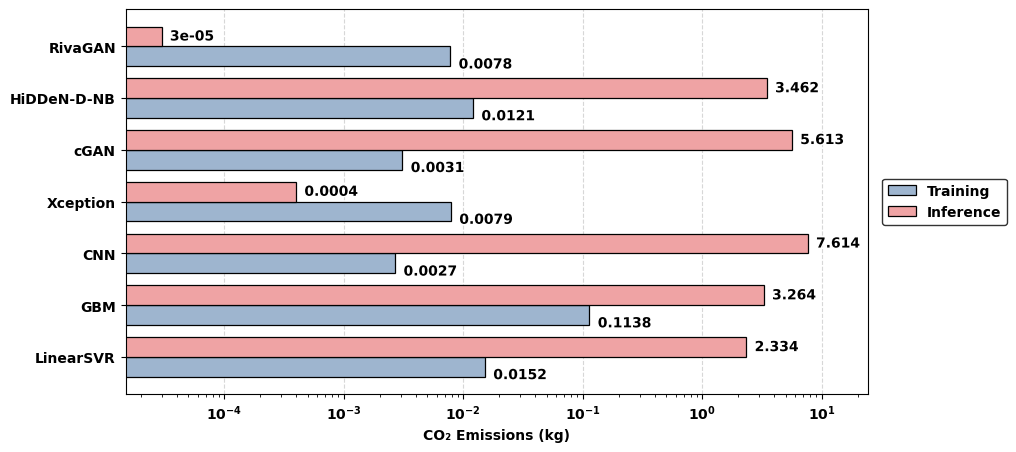

Saved: co2_emissions_combined.pdf


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.colors import to_rgb

# --- global bold defaults
plt.rcParams.update({
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "axes.titleweight": "bold",
})

def lighten(color, amount=0.4):
    r, g, b = to_rgb(color)
    return (1 - amount) + amount*r, (1 - amount) + amount*g, (1 - amount) + amount*b

models = ["LinearSVR", "GBM", "CNN", "Xception", "cGAN", "HiDDeN-D-NB","RivaGAN"]
co2_training  = [0.0152, 0.1138, 0.0027, 0.0079, 0.0031,0.0121,0.0078]
co2_inference = [2.3342, 3.2641, 7.6136, 0.0004, 5.6127,3.4620,0.00003]

USE_LOG_SCALE  = True
BAR_THICKNESS  = 0.38
LIGHTEN = 0.55

BASE_TRAIN = "#4e79a7"
BASE_INFER = "#e15759"
COLOR_TRAIN = lighten(BASE_TRAIN, LIGHTEN)
COLOR_INFER = lighten(BASE_INFER, LIGHTEN)

fig, ax = plt.subplots(figsize=(11, 5))
fig.subplots_adjust(right=0.80)

y = np.arange(len(models))
bars_train = ax.barh(y - BAR_THICKNESS/2, co2_training,  height=BAR_THICKNESS,
                     label="Training",  color=COLOR_TRAIN, edgecolor="black", linewidth=0.9, zorder=2)
bars_infer = ax.barh(y + BAR_THICKNESS/2, co2_inference, height=BAR_THICKNESS,
                     label="Inference", color=COLOR_INFER, edgecolor="black", linewidth=0.9, zorder=2)

if USE_LOG_SCALE:
    ax.set_xscale("log")
    vals = np.array(co2_training + co2_inference)
    min_pos, max_val = float(vals[vals > 0].min()), float(vals.max())
    ax.set_xlim(min_pos/2, max_val*3.2)
else:
    max_val = float(max(co2_training + co2_inference))
    ax.set_xlim(0, max_val*1.6)

ax.set_yticks(y)
ax.set_yticklabels(models, fontweight="bold")  # << make y-tick labels bold
ax.set_xlabel("CO₂ Emissions (kg)", fontweight="bold")

ax.grid(axis="x", linestyle="--", alpha=0.5, zorder=1)

# legend (bold)
leg = ax.legend(loc="center left", bbox_to_anchor=(1.01, 0.5),
                frameon=True, edgecolor="black")
for t in leg.get_texts():
    t.set_fontweight("bold")

# also make x-tick labels bold (sometimes rcParams won't catch these)
for t in ax.get_xticklabels():
    t.set_fontweight("bold")

# Labels outside both bars
def label_outside(bars, vals, dx=6, dy=0):
    for b, v in zip(bars, vals):
        ax.annotate(f"{v:.4g}",
                    xy=(max(v, 1e-12), b.get_y()+b.get_height()/2),
                    xytext=(dx, dy), textcoords="offset points",
                    ha="left", va="center", color="black",
                    fontweight="bold",  # << bold numeric labels
                    path_effects=[pe.withStroke(linewidth=2, foreground="white")],
                    zorder=3)

label_outside(bars_train, co2_training, dx=6, dy=-6)
label_outside(bars_infer, co2_inference, dx=6, dy=0)

fig.savefig("co2_emissions_combined.pdf", bbox_inches="tight")
plt.show()
print("Saved: co2_emissions_combined.pdf")


### EXTRACTION and ROBUSTNESS GRAPH

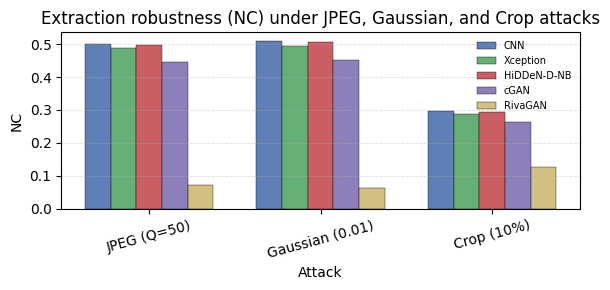

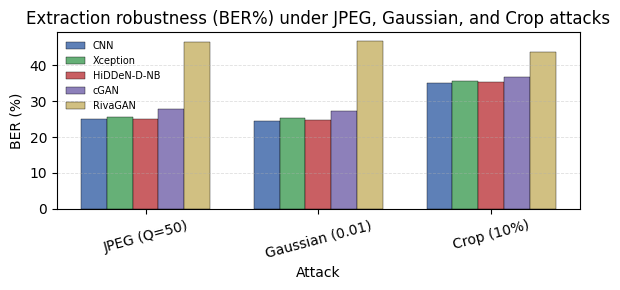

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Data (DL models)
attacks = ["JPEG (Q=50)", "Gaussian (0.01)", "Crop (10%)"]
x = np.arange(len(attacks))  # [0, 1, 2]

nc_data = {
    "CNN":         [0.5015, 0.5101, 0.2969],
    "Xception":    [0.4867, 0.4956, 0.2887],
    "HiDDeN-D-NB": [0.4984, 0.5074, 0.2934],
    "cGAN":        [0.4452, 0.4531, 0.2638],
    "RivaGAN":     [0.0716, 0.0629, 0.1265],
}

ber_data = {
    "CNN":         [24.93, 24.49, 35.16],
    "Xception":    [25.66, 25.22, 35.56],
    "HiDDeN-D-NB": [25.08, 24.63, 35.33],
    "cGAN":        [27.74, 27.34, 36.81],
    "RivaGAN":     [46.42, 46.85, 43.67],
}

models = list(nc_data.keys())

# Soft, light-ish colours for bars
colors = {
    "CNN":         "#4c72b0",  # soft blue
    "Xception":    "#55a868",  # soft green
    "HiDDeN-D-NB": "#c44e52",  # muted red
    "cGAN":        "#8172b3",  # muted purple
    "RivaGAN":     "#ccb974",  # soft mustard
}

# Bar width and offsets so clusters stay centred
width = 0.15
offsets = np.linspace(-2*width, 2*width, len(models))

# FIGURE 1: NC vs attack (BAR PLOT)
plt.figure(figsize=(6, 3))

for offset, m in zip(offsets, models):
    plt.bar(
        x + offset,
        nc_data[m],
        width=width,
        label=m,
        color=colors[m],
        alpha=0.9,
        edgecolor="black",
        linewidth=0.3,
    )

plt.xticks(x, attacks, rotation=15)
plt.ylabel("NC")
plt.xlabel("Attack")
plt.title("Extraction robustness (NC) under JPEG, Gaussian, and Crop attacks")
plt.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.4)
plt.legend(loc="upper right", fontsize=7, ncol=1, frameon=False)
plt.tight_layout()

# Save as PDF
plt.savefig("robust_nc_deep_only_bars.pdf", bbox_inches="tight", dpi=300)
plt.show()

# FIGURE 2: BER% vs attack (BAR PLOT)
plt.figure(figsize=(6, 3))

for offset, m in zip(offsets, models):
    plt.bar(
        x + offset,
        ber_data[m],
        width=width,
        label=m,
        color=colors[m],
        alpha=0.9,
        edgecolor="black",
        linewidth=0.3,
    )

plt.xticks(x, attacks, rotation=15)
plt.ylabel("BER (%)")
plt.xlabel("Attack")
plt.title("Extraction robustness (BER%) under JPEG, Gaussian, and Crop attacks")
plt.grid(True, axis="y", linestyle="--", linewidth=0.6, alpha=0.4)
plt.legend(loc="upper left", fontsize=7, ncol=1, frameon=False)
plt.tight_layout()

# Save as PDF
plt.savefig("robust_ber_deep_only_bars.pdf", bbox_inches="tight", dpi=300)
plt.show()
